In [2]:
!pip install pycaret jinja2 markupsafe==2.0.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 31.8 MB/s 
     |████████████████████████████████| 25.9 MB 45.2 MB/s 
     |████████████████████████████████| 134 kB 67.6 MB/s 
     |████████████████████████████████| 262 kB 68.3 MB/s 
     |████████████████████████████████| 17.0 MB 52.9 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 1.3 MB 55.2 MB/s 
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 1.7 MB 54.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 51.8 MB/s 
     |████████████████████████████████| 636 kB 75.4 MB/s 
     |████████████████████████████████| 167 kB 70.1 MB/s 
     |████████████████████████████████

In [1]:
import pandas as pd
import numpy as np
import os 
import jinja2
from pycaret.classification import *


In [2]:
train, test = pd.read_csv("train.csv"), pd.read_csv("test.csv")
train.head()
train.info()
test.info()
# train[train.ProductRelated_Duration.isnull()]
train["ProductRelated_Duration"] = train["ProductRelated_Duration"].fillna(0.0)
for col in ["OperatingSystems","Browser","Region","TrafficType","VisitorType"]:
    train[col] = train[col].fillna(train[col].mode().values[0])
for col in ["Informational", "Month", "Weekend"]:
    train[col] = train[col].astype(float)
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8100 non-null   int64  
 1   Administrative           8100 non-null   int64  
 2   Administrative_Duration  8100 non-null   float64
 3   Informational            8100 non-null   int64  
 4   Informational_Duration   8100 non-null   float64
 5   ProductRelated           8100 non-null   int64  
 6   ProductRelated_Duration  8099 non-null   float64
 7   BounceRates              8100 non-null   float64
 8   ExitRates                8100 non-null   float64
 9   PageValues               8100 non-null   float64
 10  SpecialDay               8100 non-null   float64
 11  Month                    8100 non-null   int64  
 12  OperatingSystems         8099 non-null   float64
 13  Browser                  8099 non-null   float64
 14  Region                  

In [3]:
val_ratio = 0.1
train_cut = int(train.shape[0] * (1-val_ratio))
train, val = train.iloc[:train_cut, :], train.iloc[train_cut:, :].reset_index(drop=True)
print(train.shape, val.shape, test.shape)

(7290, 19) (810, 19) (900, 18)


In [4]:
experiment_name = "V0"
clf = setup(
    data=train, target='Revenue', n_jobs=1, silent=True,
    preprocess=False, use_gpu=True, log_experiment=True, experiment_name=experiment_name
)

,Description,Value
0,session_id,2236
1,Target,Revenue
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(7290, 19)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Transformed Train Set,"(5102, 18)"
9,Transformed Test Set,"(2188, 18)"


INFO:logs:Logging experiment in MLFlow
2022/09/04 09:30:34 INFO mlflow.tracking.fluent: Experiment with name 'V0' does not exist. Creating a new experiment.
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Revenue',
                                      time_features=[]))],
         verbose=False), model_name=Transformation Pipeline, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_tod

In [5]:
best = compare_models(
    sort="F1", 
    include=["lr","dt","rf","knn","svm","nb","gpc","mlp","ridge","lda","qda","ada","gbc","et","lightgbm","dummy"]
)
# "Bagging", "Stacking", "Voting", "CalibratedCV"


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9010,0.9321,0.6016,0.7248,0.6564,0.5992,0.6034,1.017
lightgbm,Light Gradient Boosting Machine,0.9004,0.9284,0.5979,0.7228,0.6533,0.5959,0.6002,0.173
rf,Random Forest Classifier,0.9010,0.9237,0.5704,0.7429,0.6438,0.5876,0.5954,1.012
ada,Ada Boost Classifier,0.8857,0.9029,0.5668,0.6600,0.6076,0.5414,0.5449,0.307
et,Extra Trees Classifier,0.8944,0.9181,0.4733,0.7687,0.5840,0.5276,0.5489,0.533
dt,Decision Tree Classifier,0.8514,0.7275,0.5467,0.5270,0.5357,0.4475,0.4481,0.070
lda,Linear Discriminant Analysis,0.8783,0.8981,0.3300,0.7624,0.4591,0.4027,0.4484,0.040
lr,Logistic Regression,0.8769,0.7665,0.3541,0.6507,0.4580,0.4031,0.4276,0.907
mlp,MLP Classifier,0.8636,0.7129,0.3547,0.6589,0.4418,0.3743,0.4062,3.339
ridge,Ridge Classifier,0.8732,0.0000,0.2591,0.8017,0.3899,0.3396,0.4084,0.026


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 2
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2236, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


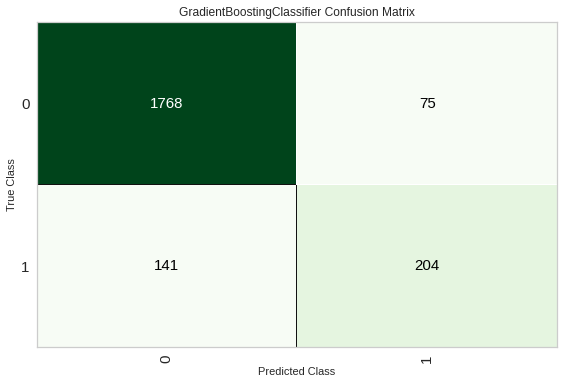

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [6]:
plot_model(best, plot="confusion_matrix")

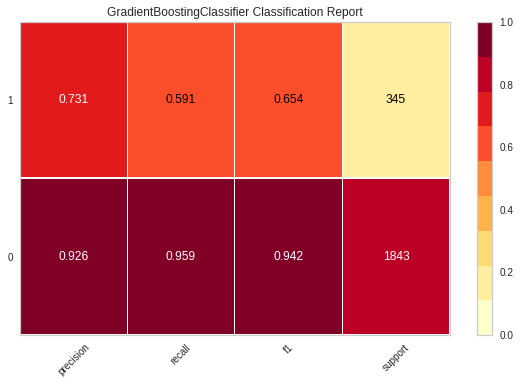

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [7]:
plot_model(best, plot="class_report")

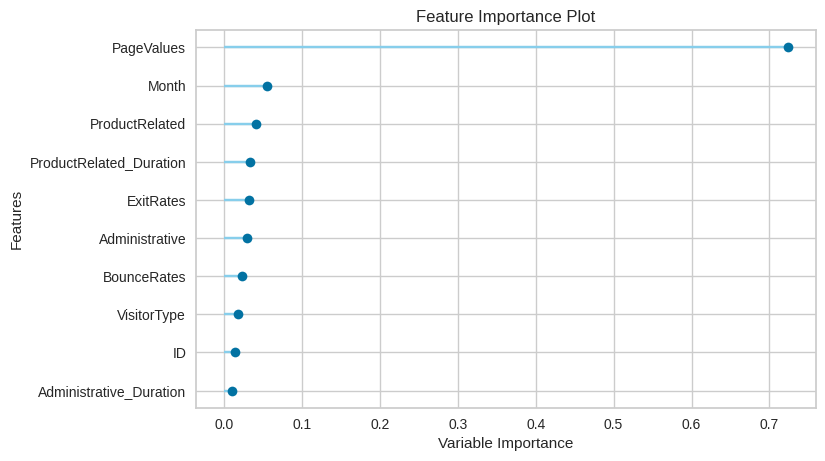

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [8]:
plot_model(best, plot='feature')


In [9]:
y_pred = predict_model(best, data=test)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2236, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloadin

In [17]:
# y_pred["prob"] = np.where(y_pred["Label"] == 1, y_pred["Score"], 1-y_pred["Score"])
y_pred[["ID","Label","prob"]].head(30)

,ID,Label,prob
0,6162,0,0.0526
1,8143,0,0.0418
2,5571,1,0.6911
3,3933,0,0.0091
4,934,0,0.0088
5,5668,0,0.0075
6,1332,0,0.0469
7,3600,1,0.9240
8,5638,0,0.0100
9,3979,0,0.0105


In [21]:
submit = y_pred[["ID","prob"]]
submit = submit.rename(columns={"prob": "HasRevenue"})
submit.head(30)

,ID,HasRevenue
0,6162,0.0526
1,8143,0.0418
2,5571,0.6911
3,3933,0.0091
4,934,0.0088
5,5668,0.0075
6,1332,0.0469
7,3600,0.9240
8,5638,0.0100
9,3979,0.0105


In [ ]:
submit.to_csv("submission.csv", index=False)


---

- 加分題

In [29]:
matrix_a = [[7230, 341],[576,853]]
perform_a = {
    "precision": round(853 / (853 + 341), 4),
    "recall": round(853 / (853 + 576), 4),
}
perform_a["F1"] = 2 * perform_a["precision"] * perform_a["recall"] / (perform_a["precision"] + perform_a["recall"])
matrix_b = [[7255, 316],[583,846]]
perform_b = {
    "precision": round(846 / (846 + 316), 4),
    "recall": round(846 / (846 + 583), 4),
}
perform_b["F1"] = 2 * perform_b["precision"] * perform_b["recall"] / (perform_b["precision"] + perform_b["recall"])

print(f"Model A: ", perform_a)
print(f"Model B: ", perform_b)


Model A:  {'precision': 0.7144, 'recall': 0.5969, 'F1': 0.6503856630824373}
Model B:  {'precision': 0.7281, 'recall': 0.592, 'F1': 0.6530341640784788}


### 結論: 選擇 Model B

由於行銷經費有限，在這兩個模型之間選擇 Precision 較高的 Model B，雖然廣告打到的訪客數會下降，但廣告的 ROI 比較高
- Model A 是對「預測為真」的 1194 位訪客打廣告，其中有消費的是 853 人，假設一次廣告成本為 10 元，則 Model A 廣告回報率為 7.14%
- Model B 是對「預測為真」的 1162 位訪客打廣告，其中有消費的是 846 人，假設一次廣告成本為 10 元，則 Model B 廣告回報率為 7.28%